# Import

In [44]:
import warnings
warnings.filterwarnings("ignore")

In [45]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import string
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data 

In [46]:
data = pd.read_csv('small_complaints.csv', engine='python', encoding='utf-8', error_bad_lines=False, sep=',')

In [47]:
data = data[["Product","Consumer complaint narrative"]]

In [48]:
data.head()

,Product,Consumer complaint narrative
0,Debt collection,transworld systems inc. \nis trying to collect...
1,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...
2,Debt collection,"Over the past 2 weeks, I have been receiving e..."
3,"Money transfer, virtual currency, or money ser...","I was sold access to an event digitally, of wh..."
4,Debt collection,While checking my credit report I noticed thre...


In [49]:
data.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    20202
Debt collection                                                                  9230
Credit card or prepaid card                                                      4332
Mortgage                                                                         3475
Checking or savings account                                                      2538
Student loan                                                                     1540
Vehicle loan or lease                                                            1083
Money transfer, virtual currency, or money service                               1019
Payday loan, title loan, or personal loan                                         880
Consumer Loan                                                                       6
Credit card                                                                         5
Payday loan                                           

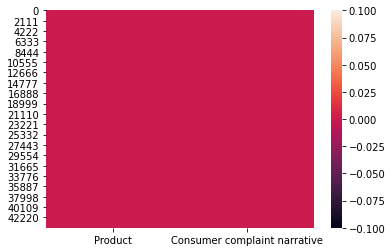

In [50]:
sns.heatmap(data.isnull())

# Preprocessing & Vizz

In [51]:
# We will group some product types 
data.loc[data['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
data.loc[data['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
data.loc[data['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
data.loc[data['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'


In [52]:
data.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    20205
Debt collection                                                                  9230
Credit card or prepaid card                                                      4337
Mortgage                                                                         3475
Checking or savings account                                                      2538
Student loan                                                                     1540
Vehicle loan or lease                                                            1083
Money transfer, virtual currency, or money service                               1019
Payday loan, title loan, or personal loan                                         885
Consumer Loan                                                                       6
Bank account or service                                                             3
Prepaid card                                          

In [53]:
# In the code below you should add : Prepaid card, Consumer Loan & Bank account or service to "Other financial service"

data = data[data.Product != 'Prepaid card']
data = data[data.Product != 'Consumer Loan']
data = data[data.Product != 'Bank account or service']
# We will not consider other financial service

data = data[data.Product != 'Other financial service']


In [54]:
data = data.reset_index(drop=True)

In [55]:
data

,Product,Consumer complaint narrative
0,Debt collection,transworld systems inc. \nis trying to collect...
1,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...
2,Debt collection,"Over the past 2 weeks, I have been receiving e..."
3,"Money transfer, virtual currency, or money ser...","I was sold access to an event digitally, of wh..."
4,Debt collection,While checking my credit report I noticed thre...
...,...,...
44307,Mortgage,"To whom it may concern, Four or five years ago..."
44308,"Credit reporting, credit repair services, or o...",FOR MONTHS I HAVE BEEN ASKING EQUIFAX TO REMOV...
44309,Credit card or prepaid card,My accounts at Capital One were closed. I trie...
44310,"Credit reporting, credit repair services, or o...",I received my Credit Report from all 3 credit ...


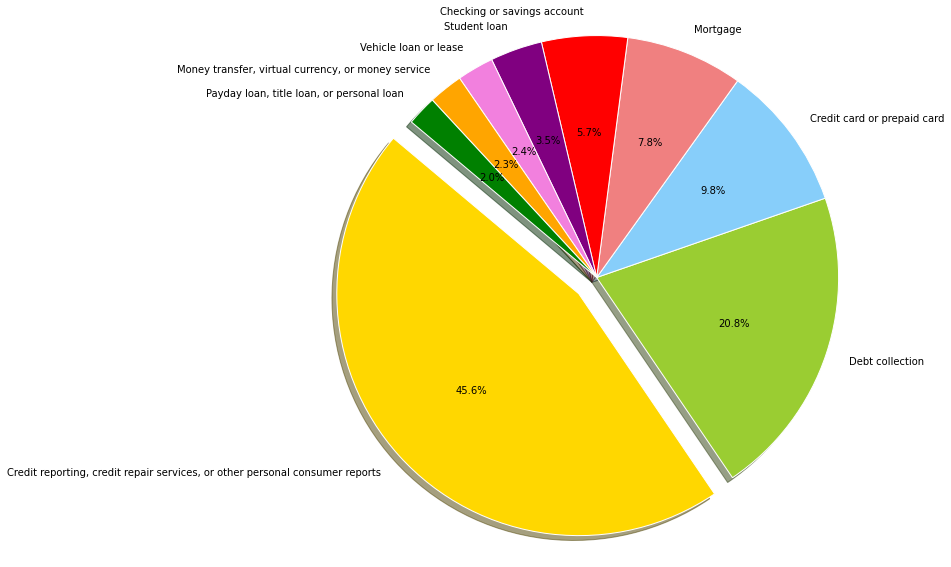

In [56]:
# Data to plot
labels = list(data.Product.value_counts().index)
sizes = list(data.Product.value_counts().values)
colors = ['gold','yellowgreen', 'lightskyblue', 'lightcoral', 'red', 'purple', '#f280de', 'orange', 'green']
explode = (0.1, 0, 0, 0,0,0,0,0,0)  # explode 1st slice

# Plot
plt.figure(figsize=(10,10))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140, wedgeprops={"edgecolor":"white"})
plt.axis('equal')
plt.show()

In [57]:
def complaint_product(indx,data):
  complaint = data['Consumer complaint narrative'][indx]
  product = data['Product'][indx]
  print(complaint)
  print('------------------------------')
  print("Product : ",product)

In [58]:
complaint_product(238, data)

I took out my XXXX XXXX loan in order to go to college. I was told when I signed up that I would get the best customer service. However, ever since I have graduated in XX/XX/XXXX, I have had nothing but trouble from them. They immediately came after me for {$550.00} a month. I was able to get my account placed on a Graduate  payment plan, but once it ended, I still was struggling to make payments as a recent graduate. When I contacted them, in XX/XX/XXXX and requested assistance in the form of refinancing due to an increase in my credit score, they refused and instead they placed me on an interest only repayment plan for {$300.00} a month, despite the fact that my cosigner had amazing credit. After that, they would make disrespectful, harassing and occasionally threatening calls to myself and my cosigner, who was in the hospital during one of  these calls. While I understand that they are a business, these calls came when I was only two days late in payment, and when I had already call

In [59]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation, remove words containing numbers, remove stop words and Xs.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\n', '', text)
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [60]:
# Code Here
data['Consumer complaint narrative'] = data['Consumer complaint narrative'].apply(clean_text) # apply clean_text function 

In [40]:
data

,Product,Consumer complaint narrative
0,Debt collection,None
1,"Credit reporting, credit repair services, or o...",None
2,Debt collection,None
3,"Money transfer, virtual currency, or money ser...",None
4,Debt collection,None
...,...,...
44307,Mortgage,None
44308,"Credit reporting, credit repair services, or o...",None
44309,Credit card or prepaid card,None
44310,"Credit reporting, credit repair services, or o...",None


In [61]:
# After cleaning
complaint_product(238, data)

took loan order go college told signed would get best customer service however ever since graduated nothing trouble immediately came month able get account placed graduate payment plan ended still struggling make payments recent graduate contacted requested assistance form refinancing due increase credit score refused instead placed interest repayment plan month despite fact cosigner amazing credit would make disrespectful harassing occasionally threatening calls cosigner hospital one calls understand business calls came two days late payment already called informed waiting paycheck would get money one point person spoke talked told learned pay time would continue getting calls would occur two five days behind payment dollar payment recent graduate never days past due every time past due due reason cant control refuses work year interest payments repayment plan almost beginning year balance went epect begin paying month come every time request form help due unable handle bill support r

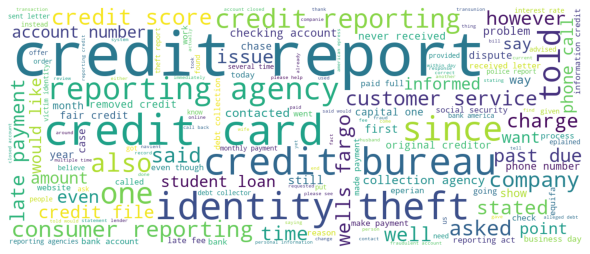

In [62]:
text = " ".join(complaint for complaint in data["Consumer complaint narrative"])
# Generate a word cloud image

wordcloud = WordCloud(width = 1200, height = 500, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(text) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [63]:
number_words = [len(complaints.split(' ')) for complaints in data["Consumer complaint narrative"]]

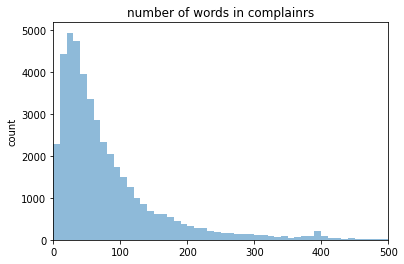

In [64]:
# fixed bin size
bins = np.arange(-0, 3000, 10) # fixed bin size

plt.xlim([0, 500])

plt.hist(number_words, bins=bins, alpha=0.5)
plt.title('number of words in complainrs')
plt.ylabel('count')

plt.show()

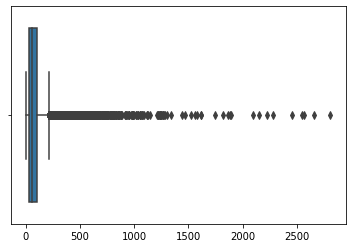

In [65]:
sns.boxplot(number_words)

# Multi-Class Text Classification LSTM 

In [66]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(data['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 40377 unique tokens.


In [67]:
X = tokenizer.texts_to_sequences(data['Consumer complaint narrative'].values)#list of integers
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH) #padding
print('Shape of data tensor:', X.shape)

Shape of data tensor: (44312, 250)


In [68]:
labels = list(pd.get_dummies(data['Product']).columns)
Y = pd.get_dummies(data['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (44312, 9)


In [69]:
# Code Here
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=50) 
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(35449, 250) (35449, 9)
(8863, 250) (8863, 9)


**Expected Output :**
(35449, 250) (35449, 9)
(8863, 250) (8863, 9)

In [70]:
# Code Here
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 9)                 909       
Total params: 5,081,309
Trainable params: 5,081,309
Non-trainable params: 0
_________________________________________________________________
None


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param   
_________________________________________________________________
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 909    
_________________________________________________________________

Total params: 5,081,309
Trainable params: 5,081,309
Non-trainable params: 0


In [71]:
epochs = 5
batch_size = 64
# Code Here
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
499/499 [==============================] - 345s 685ms/step - loss: 1.1154 - accuracy: 0.6296 - val_loss: 0.9486 - val_accuracy: 0.7018
Epoch 2/5
499/499 [==============================] - 343s 688ms/step - loss: 0.7574 - accuracy: 0.7604 - val_loss: 0.7232 - val_accuracy: 0.7659
Epoch 3/5
499/499 [==============================] - 343s 687ms/step - loss: 0.6472 - accuracy: 0.7960 - val_loss: 0.7488 - val_accuracy: 0.7599
Epoch 4/5
499/499 [==============================] - 344s 689ms/step - loss: 0.6173 - accuracy: 0.7972 - val_loss: 0.7053 - val_accuracy: 0.7848
Epoch 5/5
499/499 [==============================] - 342s 686ms/step - loss: 0.5036 - accuracy: 0.8350 - val_loss: 0.6721 - val_accuracy: 0.7955


In [72]:
# evaluate model on test set
# Code Here
score = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.2f}\n  Accuracy: {:0.2f}'.format(score[0],score[1]))

277/277 [==============================] - 18s 63ms/step - loss: 0.6986 - accuracy: 0.7815
Test set
  Loss: 0.70
  Accuracy: 0.78


Test set

  Loss: 0.66
  
  Accuracy: 0.80

In [73]:
Y_pred = model.predict(X_test)

In [74]:
predicted_classes = np.argmax(Y_pred, axis=1)

In [75]:
# Code Here
expected_classes = np.argmax(Y_test, axis=1)

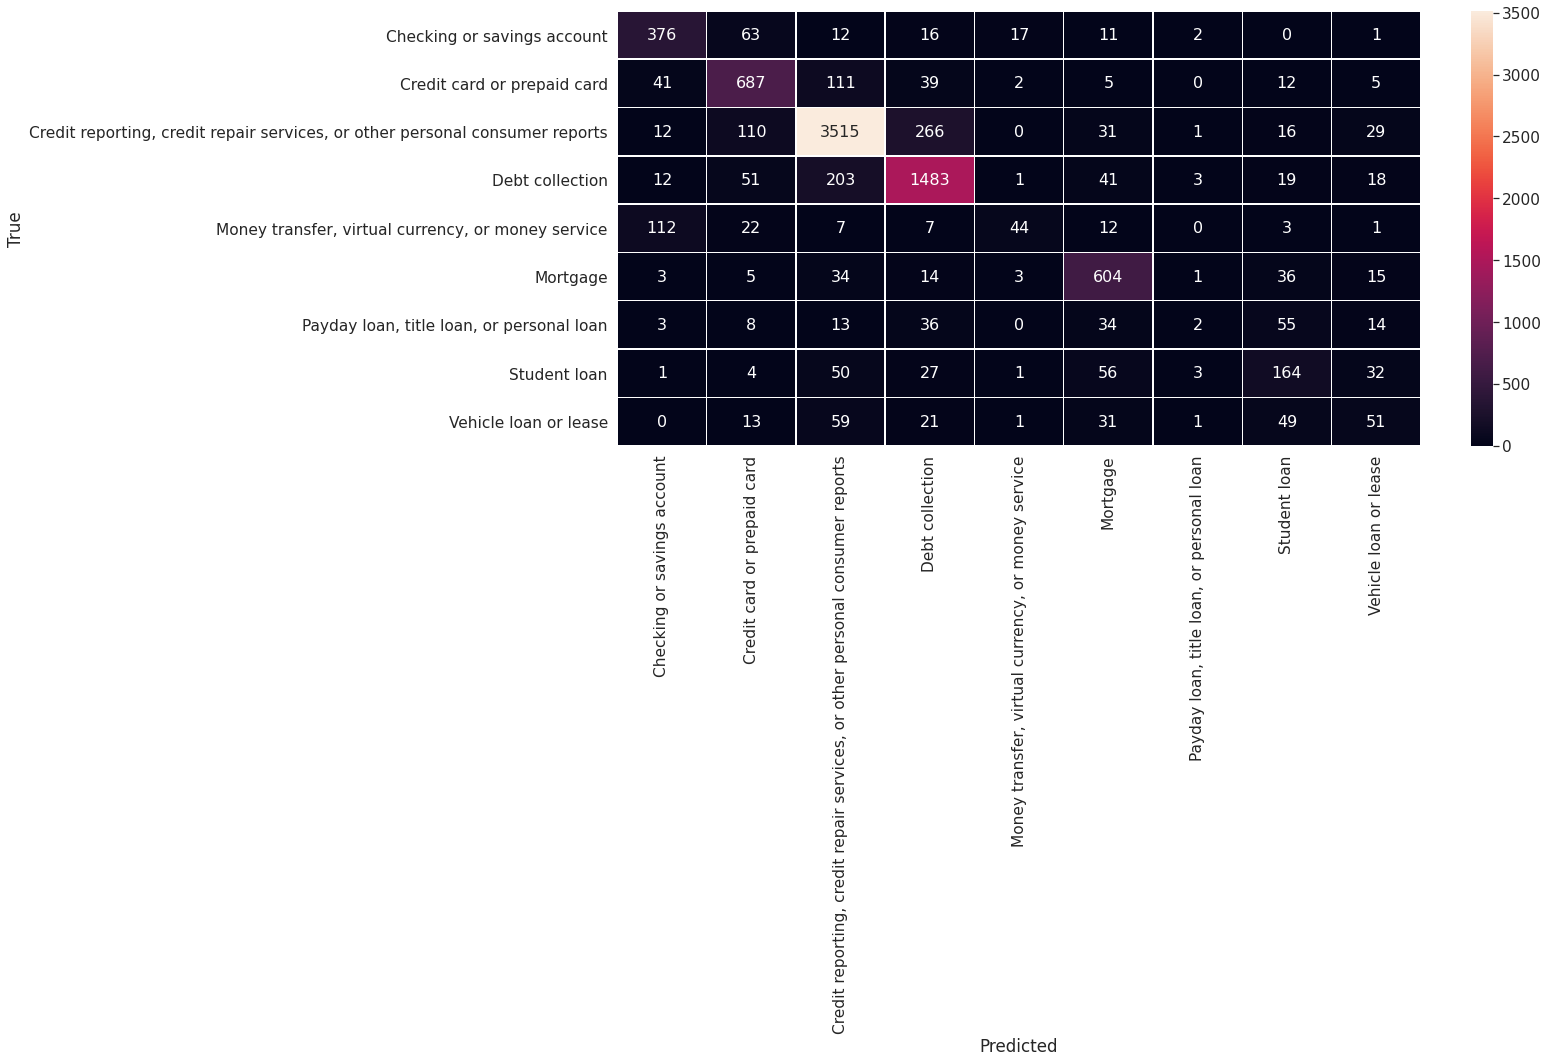

In [76]:
cm = confusion_matrix(expected_classes, predicted_classes)
plt.figure(figsize=(18,8))
sns.set(font_scale=1.4) 
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='d',linewidths=0.5, xticklabels=labels, yticklabels=labels) 
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()